# **Bài tập lớn: Phân tích biến động giá cổ phiếu Intel (INTC)**
## **Môn học: Lập trình xử lí dữ liệu với python**
**Sinh viên:**
- Nguyễn Văn Vũ - 24022493


### **I. Thu thập, xử lý dữ liệu và xây dựng tập thông số kỹ thuật cơ bản**
1. Tất cả các thư viện cần dùng

In [80]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

2. Thu thập dữ liệu

In [81]:
symbols = ['INTC', 'AMD', 'NVDA', 'QCOM']
start = datetime(2023, 7, 1)
end = datetime(2024, 12, 31)

all_data = []
for symbol in symbols:
    df = yf.Ticker(symbol).history(start=start, end=end).reset_index()
    df['Symbol'] = symbol  
    all_data.append(df)
merged_df = pd.concat(all_data, ignore_index=True)

merged_df.to_csv("data/data.csv", index=False)

                       Date       Open       High        Low      Close  \
0 2023-07-03 00:00:00-04:00  32.870018  33.213025  32.478006  32.948418   
1 2023-07-05 00:00:00-04:00  32.644612  32.664213  31.850791  31.860590   
2 2023-07-06 00:00:00-04:00  31.262776  31.399980  30.753163  31.331377   
3 2023-07-07 00:00:00-04:00  31.360779  31.762589  31.184374  31.213776   
4 2023-07-10 00:00:00-04:00  31.233380  32.174205  31.135377  32.086002   

     Volume  Dividends  Stock Splits Symbol  
0  15753000        0.0           0.0   INTC  
1  37664700        0.0           0.0   INTC  
2  41693600        0.0           0.0   INTC  
3  28345700        0.0           0.0   INTC  
4  36305700        0.0           0.0   INTC  


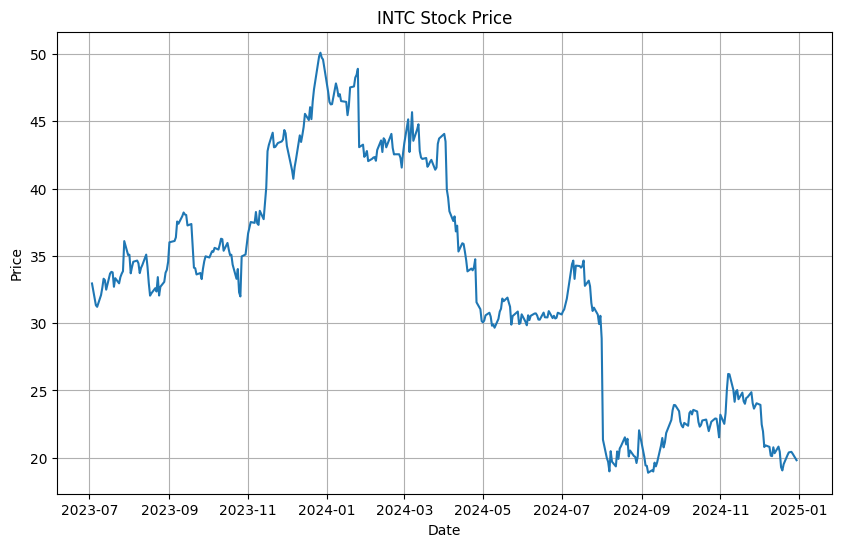

In [82]:
# Kiểm tra 5 dòng đầu
print(merged_df.head())

# Vẽ thử biểu đồ 
df = merged_df[merged_df['Symbol'] == 'INTC'].copy()
symbol = "INTC"  
plt.figure(figsize=(10, 6)) 
sns.lineplot(data=df, x='Date', y='Close')
plt.title(f'{symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

3. Làm sạch và tiền xử lý dữ liệu

In [83]:
df = pd.read_csv("data/data.csv")

# Chuyển cột ngày tháng về định dạng datetime 
df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce') 
df['Date'] = df['Date'].dt.tz_convert(None)  
df['Date'] = df['Date'].dt.normalize()

# Xóa dòng có giá trị bị thiếu (NaN)
df = df.dropna()

# Kiểm tra và loại bỏ bất thường (outliers)
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df = df[(z_scores < 3).all(axis=1)] 

# Loại bỏ 'Dividends' và 'Stock Splits' vì không ảnh hưởng trực tiếp đến phân tích kỹ thuật giá ngắn và trung hạn
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Kiểm tra định dạng
print(df.dtypes)

df_intc = df[df['Symbol'] == 'INTC']
df_intc.to_csv("data/data_clean.csv", index=False)

df_other = df[df['Symbol'].isin(['AMD', 'NVDA', 'QCOM'])]
df_other.to_csv("data/data_other.csv", index=False)

df.head()


Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Symbol            object
dtype: object


,Date,Open,High,Low,Close,Volume,Symbol
0,2023-07-03,32.870018,33.213025,32.478006,32.948418,15753000,INTC
1,2023-07-05,32.644612,32.664213,31.850791,31.860590,37664700,INTC
2,2023-07-06,31.262776,31.399980,30.753163,31.331377,41693600,INTC
3,2023-07-07,31.360779,31.762589,31.184374,31.213776,28345700,INTC
4,2023-07-10,31.233380,32.174205,31.135377,32.086002,36305700,INTC


4. Tính toán các chỉ số kỹ thuật cơ bản

In [84]:
df = pd.read_csv("data/data_clean.csv", parse_dates=['Date'])

- <small>SMA_20 & SMA_50</small>

In [85]:
# SMA: Simple Moving Average 
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

- <small>EMA_20</small>

In [86]:
# EMA: Exponential Moving Average
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

- <small>RSI_14</small>

In [87]:
# RSI: Relative Strength Index
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI_14'] = compute_rsi(df['Close'])

- <small>OBV</small>

In [88]:
# OBV: On-Balance Volume
df['OBV'] = 0
df.loc[0, 'OBV'] = df.loc[0, 'Volume']  
for i in range(1, len(df)):
    if df.loc[i, 'Close'] > df.loc[i-1, 'Close']:
        df.loc[i, 'OBV'] = df.loc[i-1, 'OBV'] + df.loc[i, 'Volume']
    elif df.loc[i, 'Close'] < df.loc[i-1, 'Close']:
        df.loc[i, 'OBV'] = df.loc[i-1, 'OBV'] - df.loc[i, 'Volume']
    else:
        df.loc[i, 'OBV'] = df.loc[i-1, 'OBV']

- <small>ATR_14</small>

In [89]:
# ATR: Average True Range       
high_low = df['High'] - df['Low']
high_prev_close = abs(df['High'] - df['Close'].shift(1))
low_prev_close = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
df['ATR_14'] = df['TR'].rolling(window=14).mean()
df.drop(columns=['TR'], inplace=True)

In [90]:
df.to_csv("data/data_clean.csv", index=False)

# Kiểm tra 50 dòng đầu tiên
df[['Date', 'Close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI_14', 'OBV', 'ATR_14']].head(50)

,Date,Close,SMA_20,SMA_50,EMA_20,RSI_14,OBV,ATR_14
0,2023-07-03,32.948418,NaN,NaN,32.948418,NaN,15753000,NaN
1,2023-07-05,31.860590,NaN,NaN,32.844815,NaN,-21911700,NaN
2,2023-07-06,31.331377,NaN,NaN,32.700678,NaN,-63605300,NaN
3,2023-07-07,31.213776,NaN,NaN,32.559068,NaN,-91951000,NaN
4,2023-07-10,32.086002,NaN,NaN,32.514014,NaN,-55645300,NaN
5,2023-07-11,32.634808,NaN,NaN,32.525519,NaN,-27496500,NaN
6,2023-07-12,33.301228,NaN,NaN,32.599396,NaN,10265700,NaN
7,2023-07-13,33.193420,NaN,NaN,32.655969,NaN,-22480100,NaN
8,2023-07-14,32.487808,NaN,NaN,32.639954,NaN,-52906300,NaN
9,2023-07-17,33.683434,NaN,NaN,32.739333,NaN,-18795100,NaN


### **II. Phân tích và trực quan hóa dữ liệu**

1. So sánh tương quan giữa Intel và các công ty cùng lĩnh vực

- <small>Tính lợi suất ngày</small>

In [91]:
# Intel (INTC)
df_intc= pd.read_csv("data/data_clean.csv", parse_dates=['Date'])
df_intc['Daily_Return'] = df_intc['Close'].pct_change()
df_intc.to_csv("data/data_clean.csv", index=False)

In [92]:
# Các cổ phiếu khác (AMD, NVDA, QCOM)
df_other = pd.read_csv("data/data_other.csv", parse_dates=['Date'])
df_other['Daily_Return'] = df_other['Close'].pct_change()
df_other.to_csv("data/data_other.csv", index=False)

In [93]:
# Trộn file
df_intc = pd.read_csv("data/data_clean.csv", parse_dates=['Date'])
df_intc = df_intc[df_intc['Symbol'] == 'INTC'][['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol', 'Daily_Return']]
df_other = pd.read_csv("data/data_other.csv", parse_dates=['Date'])
df_all = pd.concat([df_intc, df_other], ignore_index=True)


*Giá đóng của theo thời gian*

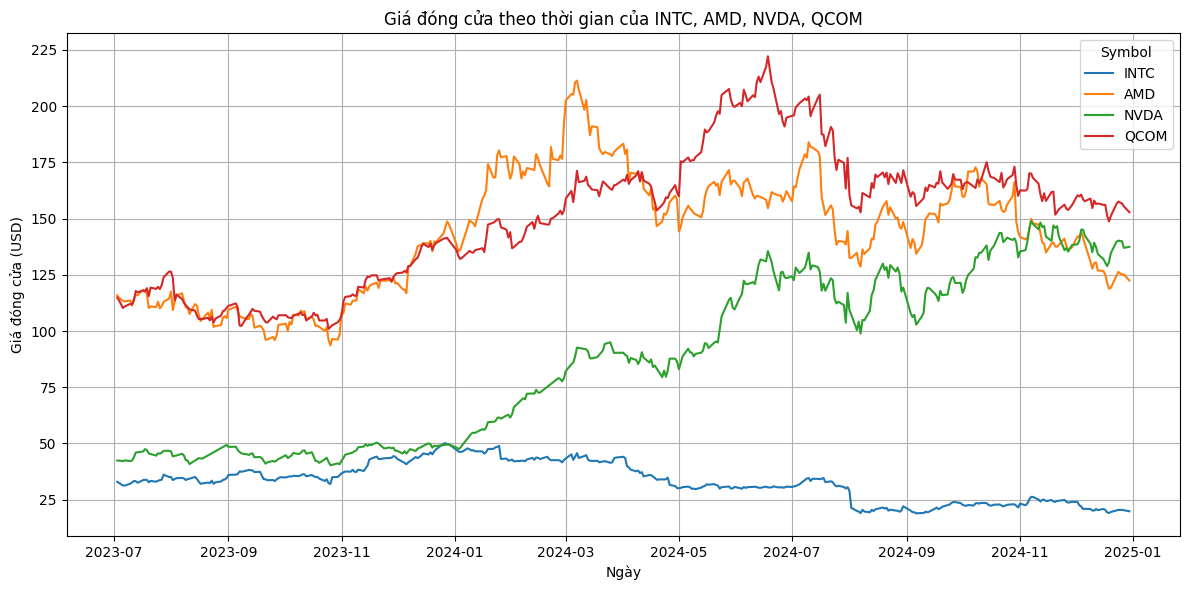

In [94]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_all, x='Date', y='Close', hue='Symbol')
plt.title("Giá đóng cửa theo thời gian của INTC, AMD, NVDA, QCOM")
plt.xlabel("Ngày")
plt.ylabel("Giá đóng cửa (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

*Lợi suất tích lũy*

C:\Users\bossg\AppData\Local\Temp\ipykernel_3984\2050665502.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_growth.index, y=final_growth.values, palette='viridis')


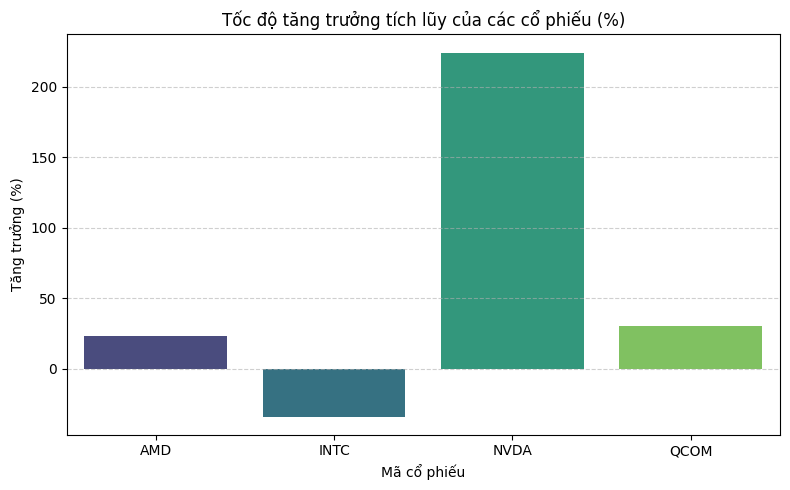

In [95]:
# Pivot lại lợi suất ngày
daily_returns = df_all.pivot(index='Date', columns='Symbol', values='Daily_Return')

# Xử lý dữ liệu thiếu (loại bỏ dòng có mã bị thiếu ngày)
daily_returns = daily_returns.dropna() 

# Tính lợi suất tích lũy
cumulative_return = (1 + daily_returns).cumprod()


# Tính tốc độ tăng trưởng cuối kỳ (%)
final_growth = (cumulative_return.iloc[-1] - 1) * 100

# Vẽ biểu đồ 
plt.figure(figsize=(8, 5))
sns.barplot(x=final_growth.index, y=final_growth.values, palette='viridis')
plt.title("Tốc độ tăng trưởng tích lũy của các cổ phiếu (%)")
plt.ylabel("Tăng trưởng (%)")
plt.xlabel("Mã cổ phiếu")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

2. Phân tích chi tiết cổ phiếu Intel (INTC)

In [96]:
df_intc = pd.read_csv("data/data_clean.csv", parse_dates=['Date'])

*Ma trận tương quan giữa Close, SMA, RSI*

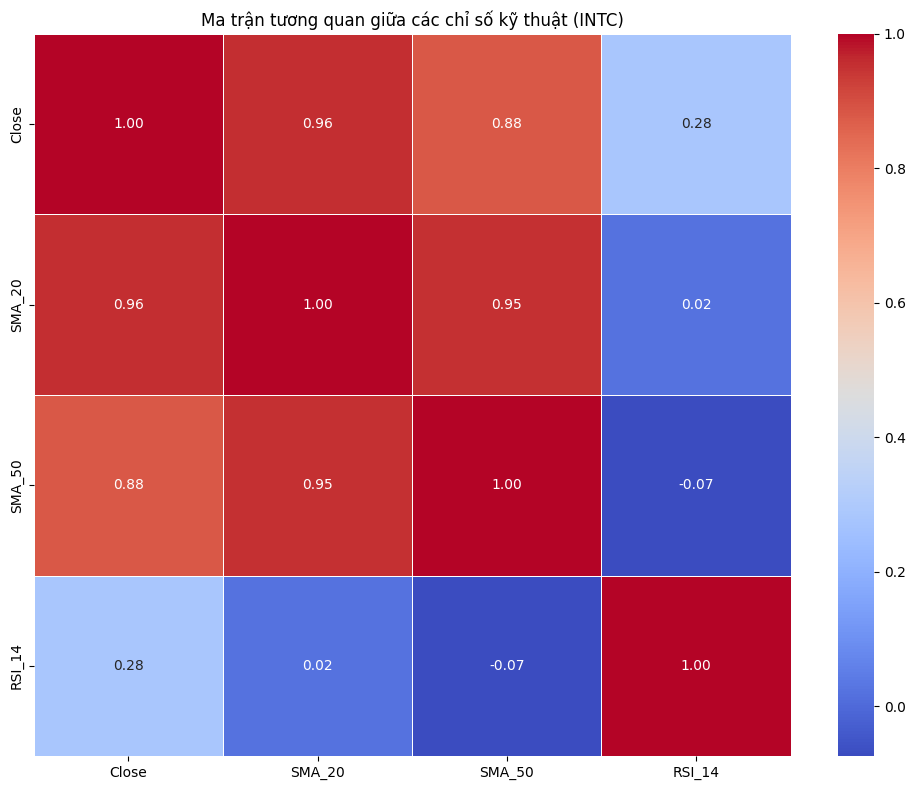

In [97]:
# Lọc chỉ các cột số 
cols = ['Close', 'SMA_20', 'SMA_50', 'RSI_14']
df_corr = df_intc[cols].dropna()

# Tính ma trận tương quan
corr_matrix = df_corr.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Ma trận tương quan giữa các chỉ số kỹ thuật (INTC)")
plt.tight_layout()
plt.show()


*Phân phối lợi suất ngày*

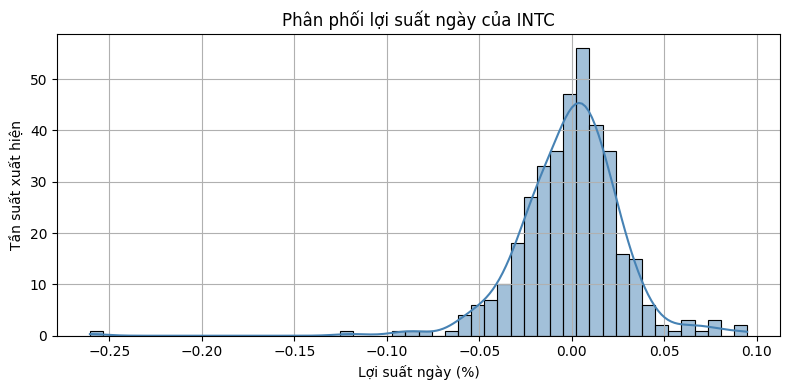

In [98]:
# Vẽ histogram
plt.figure(figsize=(8, 4))
sns.histplot(df_intc['Daily_Return'].dropna(), bins=50, kde=True, color='steelblue')
plt.title("Phân phối lợi suất ngày của INTC")
plt.xlabel("Lợi suất ngày (%)")
plt.ylabel("Tần suất xuất hiện")
plt.grid(True)
plt.tight_layout()
plt.show()

*Giá đóng cửa và các đường trung bình động*

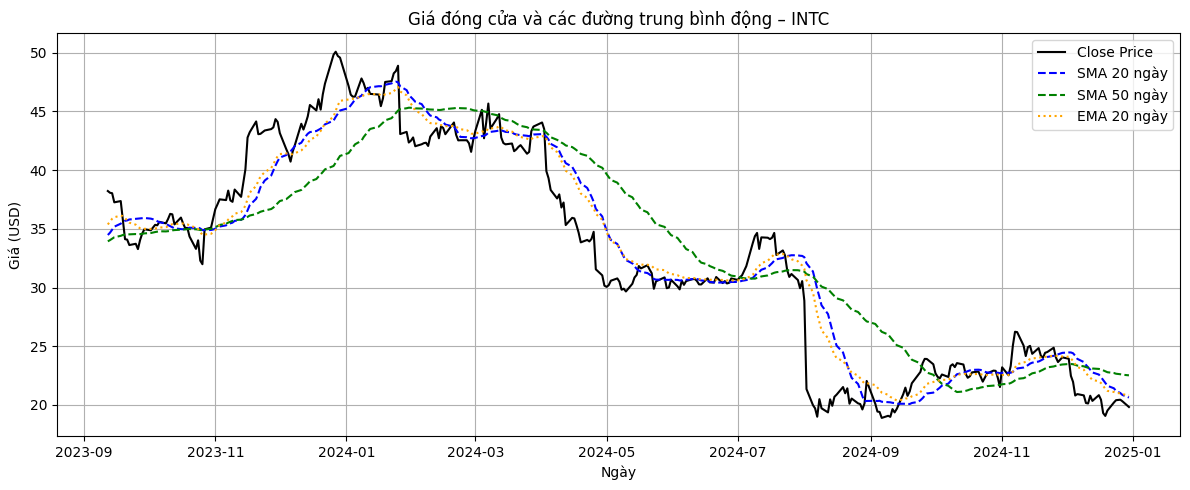

In [99]:
# Lọc dữ liệu của INTC
df = df_intc[df_intc['Symbol'] == 'INTC'].dropna(subset=['SMA_20', 'SMA_50', 'EMA_20'])

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label='Close Price', color='black', linewidth=1.5)
plt.plot(df['Date'], df['SMA_20'], label='SMA 20 ngày', linestyle='--', color='blue')
plt.plot(df['Date'], df['SMA_50'], label='SMA 50 ngày', linestyle='--', color='green')
plt.plot(df['Date'], df['EMA_20'], label='EMA 20 ngày', linestyle=':', color='orange')

# Thiết lập
plt.title("Giá đóng cửa và các đường trung bình động – INTC")
plt.xlabel("Ngày"); plt.ylabel("Giá (USD)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


*So sánh trực quan Volatility và ATR*

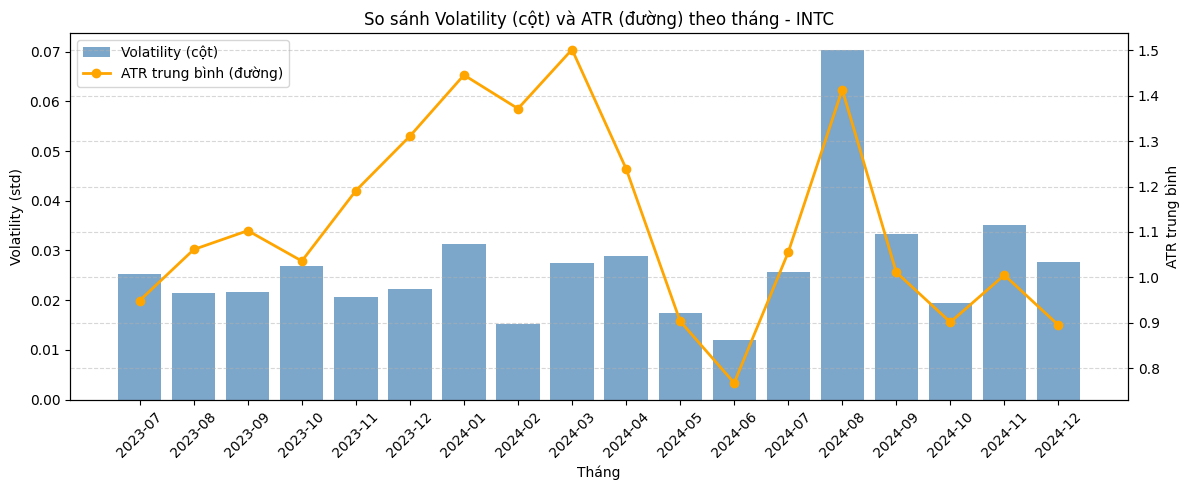

In [100]:
# Lọc dữ liệu INTC
df = df_intc[df_intc['Symbol'] == 'INTC'].copy()
df['Month'] = df['Date'].dt.to_period('M')  # Chuyển sang chu kỳ theo tháng

# Tính Volatility (độ lệch chuẩn của Daily_Return) và ATR trung bình theo tháng
summary = df.groupby('Month').agg({
    'Daily_Return': 'std',
    'ATR_14': 'mean'
}).reset_index()

# Đổi tên cột cho dễ đọc
summary.columns = ['Month', 'Volatility', 'ATR_mean']

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(12, 5))

# Vẽ cột Volatility
bars = ax1.bar(summary['Month'].astype(str), summary['Volatility'],
               color='steelblue', alpha=0.7, label='Volatility (cột)')
ax1.set_ylabel("Volatility (std)", color='black')
ax1.set_xlabel("Tháng", color='black')
ax1.tick_params(axis='x', rotation=45, colors='black')
ax1.tick_params(axis='y', colors='black')

# Vẽ đường ATR trung bình
ax2 = ax1.twinx()
line = ax2.plot(summary['Month'].astype(str), summary['ATR_mean'],
                color='orange', marker='o', linewidth=2, label='ATR trung bình (đường)')
ax2.set_ylabel("ATR trung bình", color='black')
ax2.tick_params(axis='y', colors='black')

# Tiêu đề biểu đồ
plt.title("So sánh Volatility (cột) và ATR (đường) theo tháng - INTC", color='black')

# Kết hợp chú giải của cả hai trục
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


*Đo động lượng thị trường*

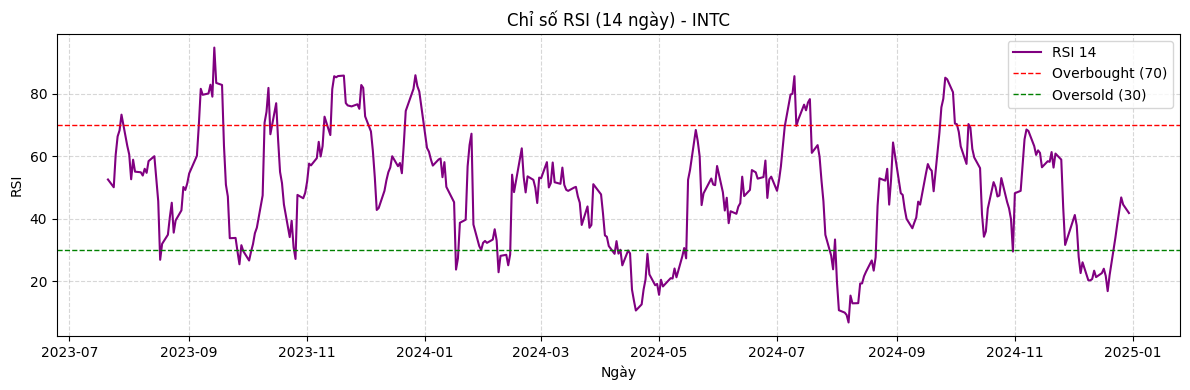

In [101]:
plt.figure(figsize=(12, 4))
plt.plot(df_intc['Date'], df_intc['RSI_14'], color='purple', linewidth=1.5, label='RSI 14')
plt.axhline(70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')

plt.title("Chỉ số RSI (14 ngày) - INTC", color='black')
plt.xlabel("Ngày", color='black')
plt.ylabel("RSI", color='black')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(colors='black')
plt.tight_layout()
plt.show()


*Phân tích dòng tiền tích lũy*

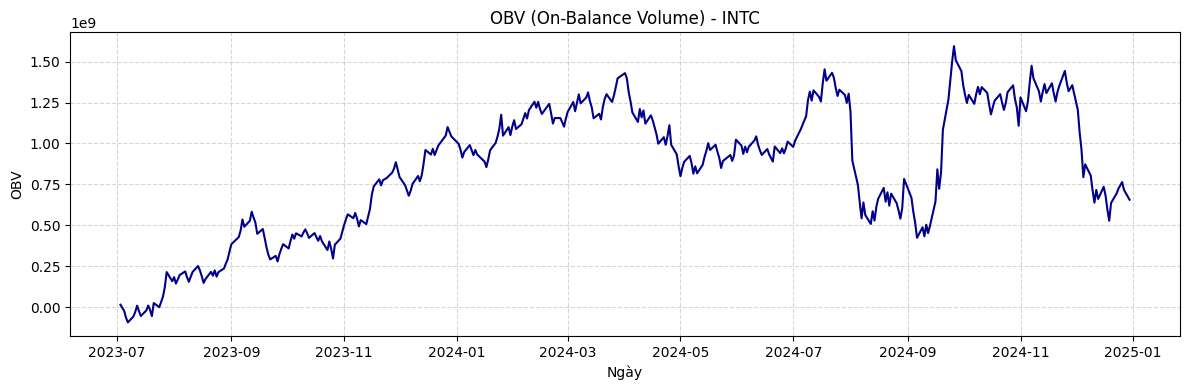

In [102]:
plt.figure(figsize=(12, 4))
plt.plot(df_intc['Date'], df_intc['OBV'], color='darkblue', linewidth=1.5)
plt.title("OBV (On-Balance Volume) - INTC", color='black')
plt.xlabel("Ngày", color='black')
plt.ylabel("OBV", color='black')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(colors='black')
plt.tight_layout()
plt.show()


### **II. Nhận xét và kết luận**

1. Tổng quan xu hướng giá

- 08/2023 – 01/2024: Cổ phiếu INTC tăng mạnh, vượt các đường trung bình động ngắn hạn và trung hạn, xác lập xu hướng tăng rõ rệt.

- 02/2024 – 06/2024: Bước vào xu hướng giảm. Giá liên tục phá vỡ các đường hỗ trợ, đi kèm dòng tiền suy yếu.

- 07/2024 – 12/2024: Giá dao động tích lũy vùng đáy (~20–25 USD), chưa xuất hiện breakout rõ ràng, phù hợp với trạng thái chờ đợi hoặc gom dần.



2. Đánh giá kỹ thuật chi tiết

*MA (SMA_20, SMA_50, EMA_20)*

- 08–11/2023: Giá cắt lên SMA_20 và EMA_20, sau đó tiếp tục duy trì trên SMA_50 → tín hiệu tăng mạnh.

- 03/2024 trở đi: Giá cắt xuống SMA và EMA, đồng thời các đường này chuyển sang hướng đi xuống → xác nhận xu hướng giảm giá.

*RSI_14*

- RSI vượt 70 trong các giai đoạn Q4/2023 và 07/2024 → vùng quá mua, dễ xuất hiện điều chỉnh.

- RSI dưới 30 vào 05, 08, 11/2024 → vùng quá bán, có thể cân nhắc mua vào khi kết hợp với các chỉ báo khác.

*Volatility & ATR_14*

- Volatility & ATR đạt đỉnh trong 08/2024 → thị trường biến động mạnh, rủi ro cao, không phù hợp để mua mới.

- Thấp nhất trong 06/2024, thể hiện thị trường ít biến động, có thể là giai đoạn tích lũy.

*OBV*

- OBV tăng mạnh từ 08/2023 đến 02/2024, xác nhận đợt tăng giá là nhờ dòng tiền thực.

- Từ 03/2024 trở đi, OBV dao động yếu và giảm nhẹ, cho thấy lực mua giảm dần.



3. Khuyến nghị đầu tư cơ bản

- **Mua:**	RSI < 30, giá giữ trên vùng hỗ trợ 20–22 USD, OBV tích lũy tăng, giá cắt lên EMA20.
- **Bán:**	RSI > 70, giá không vượt đỉnh cũ, giá cắt xuống SMA20/EMA20, OBV giảm dần.
- **Giữ:**	RSI nằm vùng 40–55, giá đi ngang trên hỗ trợ, các đường MA chưa cắt rõ ràng, dòng tiền ổn định.

4. Kết luận

<small> Trong giai đoạn 08/2023–01/2024, cổ phiếu INTC có xu hướng tăng mạnh nhờ kết quả tài chính khả quan và dòng tiền tích cực, nhưng bắt đầu từ 03/2024 đã bước vào chu kỳ điều chỉnh do tiến độ sản xuất chậm và kỳ vọng AI không đạt như dự kiến. Đỉnh biến động rơi vào tháng 08/2024 khi nhiều tổ chức hạ bậc đánh giá cổ phiếu, gây ra tâm lý tiêu cực và áp lực bán mạnh. Cuối năm 2024, giá đi ngang vùng đáy 20–25 USD, RSI cho tín hiệu quá bán và OBV bắt đầu tích lũy trở lại, phù hợp để nhà đầu tư theo dõi và cân nhắc mua dần nếu xuất hiện tín hiệu kỹ thuật xác nhận xu hướng hồi phục. <small>